<a href="https://colab.research.google.com/github/AhmadIsmail83N/MyData/blob/master/%D0%98%D0%A1__lab6_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import numpy as np
import random
import math
import tensorflow as tf
import matplotlib.pyplot as plt

**Data generation**

**Auxiliary f-I to determine the series, which is a superposition of 2x sinusoids**

In [0]:
def generate_x_y_data_two_freqs(isTrain , batch_size , seq_length):
    batch_x = [] 
    batch_y = []

    for _ in range(batch_size):
        offset_rand = random.random() * 2 * math.pi
        freq_rand = (random.random() - 0.5) / 1.5 * 15 + 0.5
        amp_rand = random.random() + 0.1
        
        sig1 = amp_rand * np.sin(np.linspace(
            seq_length / 15.0 * freq_rand * 0.0 * math.pi + offset_rand,
            seq_length / 15.0 * freq_rand * 3.0 * math.pi + offset_rand , seq_length * 2)
        )
        
        offset_rand = random.random() * 2 * math.pi
        freq_rand = (random.random() - 0.5) / 1.5 * 15 + 0.5
        amp_rand = random.random() * 1.2
        sig1 = amp_rand * np.cos(np.linspace(
            seq_length / 15.0 * freq_rand * 0.0 * math.pi + offset_rand,
            seq_length / 15.0 * freq_rand * 3.0 * math.pi + offset_rand , seq_length * 2)
        ) + sig1
        
        x1 = sig1[:seq_length]
        y1 = sig1[seq_length:]
        x_ = np.array([x1])
        y_ = np.array([y1])
        x_, y_ = x_.T, y_.T
        
        batch_x.append(x_)
        batch_y.append(y_)
        
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)
    # размерность: (batch_size , seq_length , output_dim)
    batch_x = np.array(batch_x).transpose((1, 0, 2))
    batch_y = np.array(batch_y).transpose((1, 0, 2))
    # размерность: (seq_length , batch_size , output_dim)

    return batch_x , batch_y

In [0]:
def generate_x_y_data_v2(isTrain, batch_size):
    return generate_x_y_data_two_freqs(isTrain, batch_size, seq_length=15)

**Parameter Definition НС**

In [0]:
# Данные имеют размерность (seq_length , batch_size , output_dim) 
sample_x , sample_y = generate_x_y_data_v2(isTrain=True , batch_size=3)

# Длина последовательности (в данных примерах одинаковая для обучающих и тестовых данных)
seq_length = sample_x.shape[0] 

# Размер пакета количество(тестовых примеров), по которому усредняется градиент
batch_size = 100
# Размерность выходных данных 
output_dim = input_dim = sample_x.shape[-1]
# Количество скрытых нейронов в каждой ячейке
hidden_dim = 50
# Количество ячеек рекуррентной сети (в глубину)
layers_stacked_count = 1

# Параметры оптимизатора 
# Скорость обучения маленькая (скорость обучения позволяет алгоритму не расходиться во время обучения)
learning_rate = 0.007
# Количество итераций по обучающей выборке 
nb_iters = 3000
# Дополнительные параметры алгоритма оптимизации
lr_decay = 0.75
momentum = 0.4
# Коэффициент L2 регуляризации
lambda_l2_reg = 1e-10

**Description of Computing Graph**

In [6]:
tf.nn.seq2seq = tf.contrib.legacy_seq2seq
tf.nn.rnn_cell = tf.contrib.rnn
tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
tf.reset_default_graph()
# интерактивная сессия
sess = tf.InteractiveSession()

In [8]:
with tf.variable_scope('Seq2seq'):
    enc_inp = [
        tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
            for t in range(seq_length)
    ]

    expected_sparse_output = [
        tf.placeholder(tf.float32 , shape=(None , output_dim), name="expected_sparse_output_".format(t))
            for t in range(seq_length)
    ]
    
    dec_inp = [ tf.zeros_like(enc_inp[0], dtype=np.float32 , name="GO") ] + enc_inp[:-1]
    
    cells = []
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
            
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    
    w_in = tf.Variable(tf.random_normal([input_dim , hidden_dim]))
    b_in = tf.Variable(tf.random_normal([hidden_dim], mean=1.0))
    w_out = tf.Variable(tf.random_normal([hidden_dim , output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))

    reshaped_inputs = [tf.nn.relu(tf.matmul(i, w_in) + b_in) for i in enc_inp]
    
    dec_outputs, dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(enc_inp, dec_inp, cell)
    
    output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor")
    reshaped_outputs = [output_scale_factor * (tf.matmul(i, w_out) + b_out) for i in dec_outputs]

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


**Description of loss function and optimizer**

In [0]:
with tf.variable_scope('Loss'):
    # L2 loss
    output_loss = 0
    for _y, _Y in zip(reshaped_outputs, expected_sparse_output):
        output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))

    # слагаемое, отвечающее за L2 регуляризацию
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

    loss = output_loss  + lambda_l2_reg * reg_loss

In [10]:
with tf.variable_scope('Optimizer'):
    optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
    train_op = optimizer.minimize(loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# Шаг обучения, который оптимизирует веса в соответствии с переданным минипакетом-примеров
def train_batch(batch_size):
    X, Y = generate_x_y_data_v2(isTrain=True , batch_size=batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))} 
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))}) 
    #  запускаем сессию. При этом рассчитываются тензоры, указанные в первом параметре, 
    # а значения для них берутся из второго параметра
    _, loss_t = sess.run([train_op , loss], feed_dict)
    
    return loss_t

**Training and validation НС**

In [12]:
# Тестовый прогон. Веса не обновляются благодаря тому, что переменная train_op не передается в sess.run
def test_batch(batch_size, graph=False): 
    X, Y = generate_x_y_data_v2(isTrain=False, batch_size=batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))}) 
    loss_t = sess.run([loss], feed_dict)
    
    return loss_t[0]

train_losses = []
test_losses = []
sess.run(tf.global_variables_initializer())

#nb_iters - количество шагов для обучения. После каждых 10 шагов проверяется ошибка на тестовой выборке


for t in range(nb_iters+1):
    train_loss = train_batch(batch_size)
    train_losses.append(train_loss)

    if t % 10 == 0:
        test_loss = test_batch(batch_size, t==nb_iters)
        test_losses.append(test_loss)
        print("Step {}/{}, train loss: {}, \tTEST loss: {}".format(t, nb_iters , train_loss , test_loss))

print("Fin. train loss: {}, \tTEST loss: {}".format(train_loss , test_loss))

Step 0/3000, train loss: 695.0545043945312, 	TEST loss: 469.4497985839844
Step 10/3000, train loss: 340.88824462890625, 	TEST loss: 391.8354187011719
Step 20/3000, train loss: 360.4458923339844, 	TEST loss: 323.5889892578125
Step 30/3000, train loss: 423.68780517578125, 	TEST loss: 363.19390869140625
Step 40/3000, train loss: 313.8809509277344, 	TEST loss: 285.9078063964844
Step 50/3000, train loss: 363.5986328125, 	TEST loss: 383.50689697265625
Step 60/3000, train loss: 365.3365478515625, 	TEST loss: 321.60858154296875
Step 70/3000, train loss: 323.4718322753906, 	TEST loss: 306.40478515625
Step 80/3000, train loss: 338.4772033691406, 	TEST loss: 316.2676086425781
Step 90/3000, train loss: 303.2720947265625, 	TEST loss: 323.22589111328125
Step 100/3000, train loss: 290.51873779296875, 	TEST loss: 295.0580139160156
Step 110/3000, train loss: 289.6035461425781, 	TEST loss: 269.41668701171875
Step 120/3000, train loss: 276.2729187011719, 	TEST loss: 296.9899597167969
Step 130/3000, train

**Results Visualization**

**Error dynamics in the training and test sample by iterations**

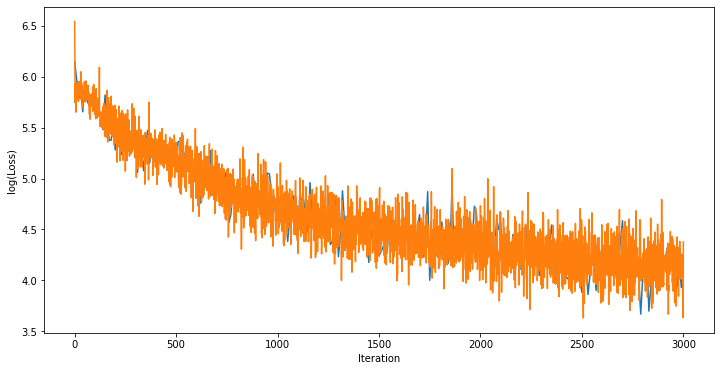

In [13]:
plt.figure(figsize=(12, 6))
plt.plot( np.array(range(0, len(test_losses)))/float(len(test_losses)-1)*(len(train_losses)-1), np.log(test_losses), label="Test loss")
plt.plot(np.log(train_losses), label="Train loss")

#log scale
plt.xlabel('Iteration')
plt.ylabel('log(Loss)') 
plt.show()

**Prediction Visualization**

 Let 's visualize 1 predictions with our signals :


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Unrecognized location 'best '. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


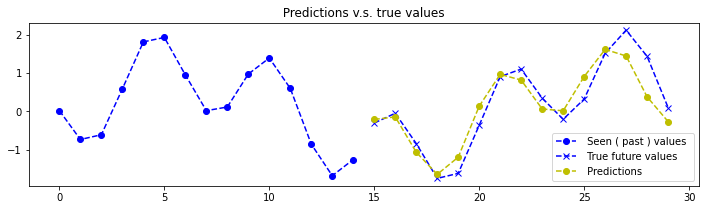

In [14]:
nb_predictions = 1
print (" Let 's visualize {} predictions with our signals :". format (nb_predictions ))
X, Y = generate_x_y_data_v2( isTrain =False , batch_size = nb_predictions )
feed_dict = { enc_inp [t]: X[t] for t in range ( seq_length )}
outputs = np.array( sess.run([ reshaped_outputs ], feed_dict )[0])
# выводим предсказания по каждому пакету
for j in range ( nb_predictions ):
    plt.figure( figsize =(12 , 3))
    for k in range ( output_dim ):
        past = X[:,j,k]
        expected = Y[:,j,k]
        pred = outputs [:,j,k]
    label1 = " Seen ( past ) values " if k ==0 else " _nolegend_ "
    label2 = " True future values " if k ==0 else " _nolegend_ "
    label3 = " Predictions " if k ==0 else " _nolegend_ "
    plt.plot(range(len(past)), past , "o--b", label = label1 )
    plt.plot(range(len(past),len(expected)+len(past)), expected, "x--b", label = label2)
    plt.plot(range(len(past),len(pred) + len (past)), pred , "o--y", label = label3 )
    plt.legend( loc ='best ')
    plt.title(" Predictions v.s. true values ")
    plt.show()